In [1]:
import os
import sys
from sys import platform
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

# Add the parent directory to the sys.path (without this we cannot import constants or scripts)
sys.path.insert(0, str(Path.cwd().parent))
from src.plotting import plot_comparison_GER_HIC_GLO
from constants.countries import highincome_countries
from src.utils import get_iso3_gbd

%load_ext autoreload

In [2]:
import matplotlib.pyplot as plt 

from tueplots import bundles
plt.rcParams.update(bundles.icml2022(column="full", ncols=1, nrows=1))

In [3]:
# if platform == 'darwin': # macos
#     print('mac os')
#     os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [4]:
DATA_PATH = '../data/final'
OUTPUT_PATH = '../doc/IHD_germany_2024/fig'
cvd_data_path = f'{DATA_PATH}/gbd_cardiovascularglobal.csv'
YEAR_COLUMN_NAME = 'year'
VALUE_COLUMN_NAME = 'val'

## Load Data

In [5]:
df = pd.read_csv(cvd_data_path)
df = df[df['age_name'] == 'All ages']
df.drop(columns=['measure_id', 'location_id', 'sex_id', 'sex_name', 'metric_id', 'upper', 'lower', 'age_name', 'age_id'], inplace=True)
df = df[df.measure_name=='Incidence']
df['country_code'] = df['location_name'].map(get_iso3_gbd)

In [6]:
df = df[['location_name', 'country_code', 'year', 'val']]
df.columns = ['Country Name', 'Country Code', 'Year', 'IHD']

In [7]:
df['Country Code'].nunique()

204

In [8]:
year_cols = [str(i) for i in range(1960, 2023)]

In [9]:
health_df = pd.read_csv('../data/raw/health_expenditure.csv')
health_df = health_df.melt(id_vars=['Country Name', 'Country Code'], value_vars=year_cols, var_name='Year', value_name='HealthInd')
health_df['Year'] = health_df['Year'].astype(int)
health_df = health_df.drop(['Country Name'], axis=1)
health_df = health_df.dropna()

In [10]:
health_df.dropna()['Country Code'].nunique()

238

In [11]:
# health_df = pd.read_csv(DATA_PATH+'/oecd_combined_final.csv')
# health_df = health_df.rename({'Value': 'HealthInd'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [12]:
fat_df = pd.read_csv(DATA_PATH+'/daily_per_capita_fat_supply_final.csv')
fat_df = fat_df.rename({'Value': 'Fat'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [13]:
alc_df = pd.read_csv(DATA_PATH+'/wdi_AlcoholConsumption.csv')
alc_df = alc_df.rename({'Value': 'Alcohol'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [14]:
age_df = pd.read_csv('../data/raw/median-age.csv')
age_df = age_df[['Code', 'Year', 'Median age - Sex: all - Age: all - Variant: estimates']]
age_df.columns = ['Country Code', 'Year', 'Age']

In [15]:
final_df = df.merge(health_df, on=['Country Code', 'Year'])
final_df = final_df.merge(alc_df, on=['Country Code', 'Year'])
final_df = final_df.merge(fat_df, on=['Country Code', 'Year'])
final_df = final_df.merge(age_df, on=['Country Code', 'Year'])

In [16]:
final_df

,Country Name,Country Code,Year,IHD,HealthInd,Alcohol,Fat,Age
0,Sri Lanka,LKA,2000,442.270854,4.246541,1.87767,44.464270,26.4
1,Sri Lanka,LKA,2005,485.069859,4.009726,2.05690,43.960644,27.8
2,Sri Lanka,LKA,2010,511.629689,3.867456,2.60332,42.958050,29.2
3,Sri Lanka,LKA,2015,559.694339,3.889920,2.86093,48.162490,30.8
4,Sri Lanka,LKA,2019,600.674503,3.661538,2.82954,52.527122,32.0
...,...,...,...,...,...,...,...,...
822,Saint Kitts and Nevis,KNA,2000,630.783889,4.799338,6.45746,82.733665,25.6
823,Saint Kitts and Nevis,KNA,2005,611.372733,4.728038,7.78943,84.758514,27.5
824,Saint Kitts and Nevis,KNA,2010,638.710629,5.213694,6.46794,92.144260,29.4
825,Saint Kitts and Nevis,KNA,2015,696.196486,5.117984,6.11651,107.441960,31.4


In [17]:
mean_df = final_df.groupby(['Country Name', 'Country Code'])[['IHD', 'HealthInd', 'Alcohol', 'Fat', 'Age']].last().reset_index()

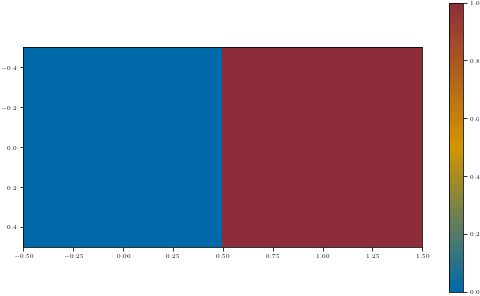

In [18]:
from tueplots.constants.color import rgb

from matplotlib.colors import LinearSegmentedColormap

cmap_colors = [
    (0.0, rgb.tue_blue),
    (0.5, rgb.tue_orange),
    (1.0, rgb.tue_red)
]

# Create a colormap object
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

# Use this colormap
plt.imshow([[0,1]], cmap=custom_cmap)
plt.colorbar()
plt.show()

In [24]:
def bubble_plot_factors_and_rates(input_df, x_col, y_col, size_col, hue_col, country_col,
                                x_label, y_label, size_label, hue_label, min_dist,
                                title, output_path
                                ):
    df = input_df.copy()
    df[size_col + '_rescaled'] = (df[size_col] - df[size_col].min()) * 10
    scatter = plt.scatter(df[x_col], 
                        df[y_col], 
                        s=df[size_col+'_rescaled'],  # This argument specifies the size of the bubbles,
                        alpha=0.5, c=df[hue_col], cmap=custom_cmap)

    # Add labels for the x and y axes
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # white_list = ['Germany', 'United States of Ameria', 'United Kingdom', 'United ']
    coords = np.zeros(shape=(len(df), 2))

    # Optionally add country labels
    for i, row in df.iterrows():
        # if row['Country Name'] in highincome_countries:
        curr_coord = np.array([row[x_col], row[y_col]])
        dist = np.linalg.norm(curr_coord.reshape(-1,2) - coords, axis=1)
        # print(coords)
        coords[i] = curr_coord
        if dist.min() > min_dist or row[country_col] == 'Germany':
            plt.text(row[x_col], 
                    row[y_col], 
                    s=row[country_col], 
                    fontsize=5)

    plt.colorbar(scatter, label=hue_label)

    pct = [20, 50, 80]
    legend_sizes = np.percentile(df[size_col + '_rescaled'], pct)
    # print(legend_sizes)
    legend_labels_int = [str(int(age)) for age in np.percentile(df[size_col], pct)]
    legend_labels = [None, None, None]
    legend_labels[0] = "under " + legend_labels_int[0]
    legend_labels[1] = "from " + legend_labels_int[0] + " to " + legend_labels_int[2]
    legend_labels[2] = "above " + legend_labels_int[2]

    # Create a list of legend entries
    legend_entries = [plt.scatter([], [], s=size, color='grey', label=label)
                    for label, size in zip(legend_labels, legend_sizes)]
    plt.legend(handles=legend_entries, title=size_label, ncol=3, loc='upper left')

    plt.title(title)

    plt.savefig(output_path)
    plt.show()

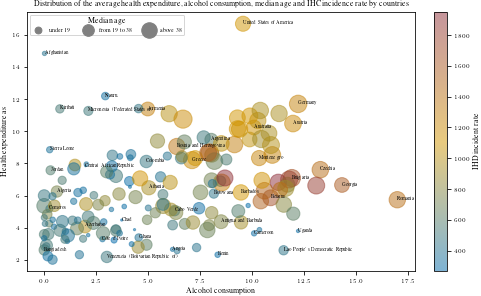

In [26]:
output_fig_path = OUTPUT_PATH + '/fig_bubble_plot_factors.pdf'
bubble_plot_factors_and_rates(mean_df, x_col='Alcohol', y_col='HealthInd', size_col='Age', hue_col='IHD',
                            x_label='Alcohol consumption', y_label='Health expenditure (% of GDP)',
                            size_label='Median age', hue_label='IHD incident rate',
                            country_col='Country Name', min_dist=1.1, 
                            title='Distribution of the average health expenditure, alcohol consumption, median age and IHC incidence rate by countries',
                            output_path=output_fig_path)   